In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.formula.api as smf
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from numba import jit
import datetime
from sklearn import cluster
from sklearn import mixture

C:\Program Files\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
# import data
sessions = pd.read_csv('c:/users/matt/desktop/poker paper/opp.csv')

# Clean Sessions dataset
sessions['Session Start'] = pd.to_datetime(sessions['Session Start'])
#sessions = sessions.drop('Unnamed: 0', axis=1)

sessions['My C Won'] = sessions['My C Won'].replace(to_replace='\$',value='', regex=True).\
                       replace(to_replace='\,',value='', regex=True).astype('float')
sessions['Won'] = sessions['Won'].replace(to_replace='\$',value='', regex=True).\
                       replace(to_replace='\,',value='', regex=True).astype('float')
sessions['BB vs SB call won'] = sessions['BB vs SB call won'].replace(to_replace='\$',value='', regex=True).\
                       replace(to_replace='\,',value='', regex=True).astype('float')
sessions['won when 3bet pre'] = sessions['won when 3bet pre'].replace(to_replace='\$',value='', regex=True).\
                       replace(to_replace='\,',value='', regex=True).astype('float')
    
sessions['Hands'] = sessions['Hands'].\
                       replace(to_replace='\,',value='', regex=True).astype('float')

for var_name in ['Fold BB v SB', 'VPIP', 'CBet F', '3Bet PF',
       'StdDev(BB/100)', 'BB/100',
       'All-In Adj BB', 'My C StdDev', 'StdDev', 'WWSF', 'WTSD %',
       'My C Rake Share', 'Rake Share', 'Total AF', 'Donk F', 'Att To Steal']:
    sessions[var_name] = pd.to_numeric(sessions[var_name].\
                                           replace('\$','',regex=True).\
                                           replace(to_replace='\,',value='', regex=True)
                                  , errors='coerce')

In [3]:
sessions.drop('Unnamed: 0', 1)
sessions.fillna(0.0, inplace=True)

In [4]:
before = sessions[sessions['Session Start'] < "2014-11-03"]
during = sessions[sessions['Session Start'] > "2014-11-03"]
during = during[during['Session Start'] < "2015-01-06"]
after = sessions[sessions['Session Start'] > "2015-01-06"]

players_before = list(set(before['Player']) & set(during['Player']))
players_after = list(set(during['Player']) & set(after['Player']))
players_list = list(set(players_before + players_after))

sessions['ephemeral'] = ~sessions['Player'].isin(players_list)
sessions['ephemeral opp'] = ~sessions['Opponent'].isin(players_list)

# Labeling

In [5]:
# Create weighed averages in groups
hands_weights = np.array(sessions['Hands'])
tmp = sessions.drop('Session Start', 1)\
        .drop('Player', 1).drop('ephemeral opp', 1)\
        .drop('Opponent', 1)
sessions_avg = hands_weights[:, None] * tmp
sessions_avg['Player'] = sessions['Player']

In [6]:
# Group by player name
sessions_sum = sessions.groupby(sessions['Player']).sum()
sessions_avg = sessions_avg.groupby(sessions_avg['Player']).sum()
sessions_avg.drop('Player', 1, inplace=True)

# Divide results in sessions average by sum weight
hands_sum_weights = np.array(sessions_sum['Hands'])
sessions_avg = np.divide(sessions_avg, hands_sum_weights[:, None])

# Create cross-section of players over sample
players = sessions_avg.drop(sessions_avg.columns, 1)
players['Sessions'] = sessions_sum['Sessions']
players['Minutes tot'] = sessions_sum['Minutes']
players['Minutes avg'] = sessions_avg['Minutes']
players['Hands tot'] = sessions_sum['Hands']
players['Hands avg'] = sessions_avg['Hands']

# Winnings with RB
players['Winnings'] = sessions_sum['My C Won'] + 0.4*sessions_sum['My C Rake Share']

players['My C Won tot'] = sessions_sum['My C Won']
players['My C Won avg'] = sessions_avg['My C Won']
players['My C StdDev avg'] = sessions_avg['My C StdDev']
players['My C Rake Share tot'] = sessions_sum['My C Rake Share']
players['My C Rake Share avg'] = sessions_avg['My C Rake Share']
players['All-In Adj BB tot'] = sessions_sum['All-In Adj BB']
players['All-In Adj BB avg'] = sessions_avg['All-In Adj BB']
players['BB/100 tot'] = sessions_sum['BB/100']
players['BB/100 avg'] = sessions_avg['BB/100']
players['StdDev(BB/100) tot'] = sessions_sum['StdDev(BB/100)']
players['StdDev(BB/100) avg'] = sessions_avg['StdDev(BB/100)']

for col_name in ['Fold BB v SB', 'VPIP',
                 'CBet F', '3Bet PF', 'WWSF', 'WTSD %', 'Total AF',
                 'Donk F', 'Att To Steal']:
    players[col_name] = sessions_avg[col_name]

In [7]:
# Fill NaN values in players to 0
players.fillna(0, inplace=True)

In [8]:
#players.sort_values(by='Minutes tot', ascending=False)

# Cluster

In [9]:
k_means = cluster.KMeans(init='k-means++', n_clusters=2, n_init=10).fit(players)
players['k means'] = k_means.labels_
k_means3 = cluster.KMeans(init='k-means++', n_clusters=3, n_init=10).fit(players)
players['k means3'] = k_means3.labels_

In [10]:
agglo = cluster.AgglomerativeClustering(n_clusters=2).fit(players)
players['agglo'] = agglo.labels_
agglo3 = cluster.AgglomerativeClustering(n_clusters=3).fit(players)
players['agglo3'] = agglo3.labels_

In [11]:
#gauss_mix = mixture.GaussianMixture(n_components=2).fit(players)

** Parametric Clustering **

In [12]:
# T statistic on if player is an AIEV winner
# (amt_expected_bb_won)/(sqrt((cnt_hands / 100)*(val_stddev_bb)*(val_stddev_bb))) 
players['t stat won'] = (players['All-In Adj BB tot'] / 
                           np.sqrt(players['Hands tot'] / 100 * 
                           (players['StdDev(BB/100) avg']**2)
                           ))

players['t stat won C'] = (players['Winnings'] / 
                           np.sqrt(players['Hands tot'] * 
                           (players['My C StdDev avg']**2)
                           ))
#
# Cluster on prob of being a winner
#
players['is winner'] = ((players['Minutes tot'] > 3600) & (players['t stat won'] > 1.645))
players['is winner C'] = ((players['Minutes tot'] > 3600) & (players['t stat won C'] > 1.645))

** Plot Clusters **

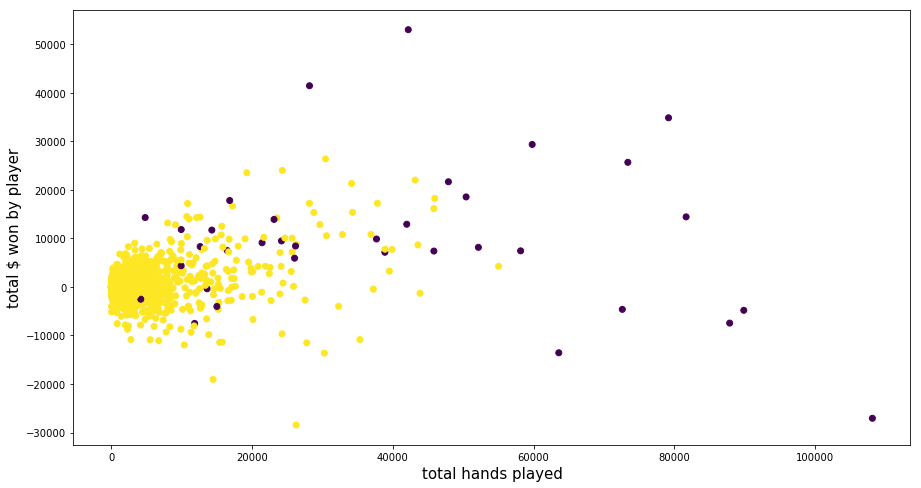

In [13]:
# ScatterPlot of hands played vs $ won total
xsize=15
ysize=8
fig, ax1 = plt.subplots(figsize=(xsize, ysize))
ax1.set_ylabel('total $ won by player', size=15)
ax1.set_xlabel('total hands played', size=15)
scat = plt.scatter(players['Hands tot'], players['Winnings'], c=1 - players['k means'])

plt.show()

In [14]:
np.sum(1- players['k means'])

12019

In [16]:
k_means_good = players[players['k means'] == 1]
k_means_bad = players[players['k means'] != 1]
agglo_good = players[players['agglo'] == 1] # Verify this is always the same
agglo_bad = players[players['agglo'] != 1]
t_C_good = players[players['is winner C'] == 1]
t_C_bad = players[players['is winner C'] != 1]
t_good = players[players['is winner'] == 1]
t_bad = players[players['is winner'] != 1]

# Output to data

In [31]:
sessions_new = sessions
agglo_names = players[players['agglo'] == 1].index
k_means_names = players[players['k means'] == 1].index
t_C_names = players[players['is winner C'] == 1].index
t_names = players[players['is winner'] == 1].index

sessions_new['agglo'] = (1 - sessions_new['Player'].isin(agglo_names))
sessions_new['k means'] = (sessions_new['Player'].isin(k_means_names)).astype(int)
sessions_new['t_C_cluster'] = (sessions_new['Player'].isin(t_C_names)).astype(int)
sessions_new['t_cluster'] = (sessions_new['Player'].isin(t_names)).astype(int)
sessions_new['before/during'] = (sessions_new['Player'].isin(players_before)).astype(int)
sessions_new['during/after'] = (sessions_new['Player'].isin(players_after)).astype(int)

sessions_new['agglo opp'] = (1 - sessions_new['Opponent'].isin(agglo_names))
sessions_new['k means opp'] = (sessions_new['Opponent'].isin(k_means_names)).astype(int)
sessions_new['t_C_cluster opp'] = (sessions_new['Opponent'].isin(t_C_names)).astype(int)
sessions_new['t_cluster opp'] = (sessions_new['Opponent'].isin(t_names)).astype(int)
sessions_new['before/during opp'] = (sessions_new['Opponent'].isin(players_before)).astype(int)
sessions_new['during/after opp'] = (sessions_new['Opponent'].isin(players_after)).astype(int)

In [34]:
sessions_new.to_csv('c:/users/matt/desktop/opponents.csv', encoding='utf8')